In this notebook I use George to fit a DRW light curve

First, simulate a DRW  :

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
import celerite
import modules as mod
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

# Initialize George...
import george
print(george.__version__)
from george import kernels

In [137]:
# make a well-sampled DRW light curve ,
# at least 10 times longer than the input timescale ... 
%matplotlib inline
t = np.linspace(0,10000,500)
SFinf  = 0.2 
tau = 100

def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).
       
       Note:  sampling times t  must be a sorted array ! 
    '''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag

y  = sim_DRW_lightcurve(t,SFinf,tau,17)
yerr = 0.01
yobs = y + yerr * np.random.normal(loc=0,scale=1, size=len(y))

#plt.errorbar(t,yobs, yerr)
sigma_input = SFinf / np.sqrt(2)
print('input (DRW  units):  tau= ', tau, ' sigma= ', sigma_input)
print('input (George units): log(a)  = ', np.log(sigma_input**2.0), 
     'log(M_00)=log(l^2)=', np.log(tau**2.0))


# define a kernel 
a = sigma_input ** 2.0 
k = a *  kernels.ExpKernel(metric=tau**2.0) # metric = length_scale ^2 

# compute 
gp = george.GP(k,  mean=np.mean(yobs))
gp.compute(t, yerr)

print(gp.get_parameter_dict())


# plot the predictuion given that we 
# set the kernel to be the real values ...
#x_pred = np.linspace(min(t), max(t),  500)
#pred, pred_var = gp.predict(yobs, x_pred, return_var=True)

#plt.fill_between(x_pred, pred - 3*np.sqrt(pred_var), 
#                         pred + 3*np.sqrt(pred_var),
#                color="k", alpha=0.2)
#plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
#plt.errorbar(t, yobs, yerr=yerr, fmt=".k", capsize=0)

input (DRW  units):  tau=  100  sigma=  0.141421356237
input (George units): log(a)  =  -3.91202300543 log(M_00)=log(l^2)= 9.21034037198
OrderedDict([('kernel:k1:log_constant', -3.912023005428146), ('kernel:k2:metric:log_M_0_0', 9.2103403719761836)])


sigma_fit= 0.131101372336 tau_fit= 84.2770951009


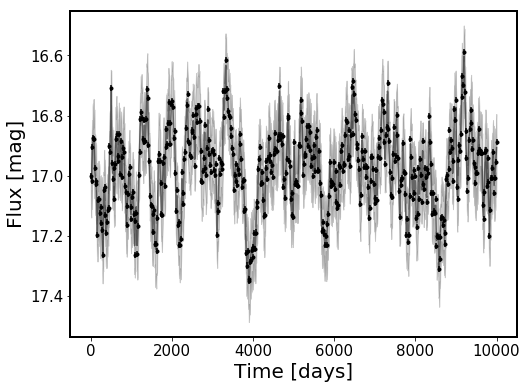

In [141]:
prior = 'Jeff2'
# define nll : the objective function
def neg_log_posterior(params,y,gp,prior):
    gp.set_parameter_vector(params)
    if prior is 'None' : 
        return -gp.log_likelihood(y, quiet=True)

    if prior is 'Jeff1' : # (1/sigma) * (1/tau)
        # the one that seems to better match the problem at hand 
        # given that the fitted parameters are 
        # sigma and tau  
        log_a  , neg_log_c =  params
        log_c = - neg_log_c
        log_prior = - (log_a / 2.0) + log_c
        return -gp.log_likelihood(y, quiet=True) - log_prior

    if prior is 'Jeff2' : # (1/sigma_hat) * (1/tau) 
        # the one used by Kozlowski , 
        # as well as Chelsea... 
        log_a  , neg_log_c =  params
        log_c = -neg_log_c
        log_prior  = 0.5* (-np.log(2.0) - log_a + log_c  )
        return -gp.log_likelihood(y, quiet=True) - log_prior
    
# wrap the neg_log_posterior for a chosen prior 
def neg_log_like(params,y,gp):
    return neg_log_posterior(params,y,gp,prior)


# minimize the log posterior defined above 
sig_min, sig_max = 0.01, 1.0 
tau_min, tau_max = 1,10000

log_const_bounds =  ( np.log(sig_min**2.0), np.log(sig_max**2.0))
log_M00_bounds =  (np.log(tau_min**2.0), np.log(tau_max**2.0))
bounds =  [log_const_bounds, log_M00_bounds]
r = minimize(neg_log_like, gp.get_parameter_vector(), 
                 method="L-BFGS-B",bounds=bounds, args=(yobs, gp))

# update params to be the MAP values found above 
gp.set_parameter_vector(r.x)

# print the params...
a = np.exp(r.x[0])
l2 =  np.exp(r.x[1])
sigma_fit = np.sqrt(a)
tau_fit = np.sqrt(l2)
print('sigma_fit=', sigma_fit,  'tau_fit=', tau_fit)

# plot the new prediction
x_pred = np.linspace(min(t),max(t), 1500)
pred, pred_var = gp.predict(yobs, x_pred, return_var=True)

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.fill_between(x_pred, pred - 3*np.sqrt(pred_var), pred + 3*np.sqrt(pred_var),
                color="k", alpha=0.2)
ax.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
ax.invert_yaxis()
ax.set_xlabel('Time [days]')
ax.set_ylabel('Flux [mag]')

So we can reproduce the input values (I didn't expect perfect reproduction due to stochastic nature of the process - but reproducing Fig.2 of Kozlowski+2017 should be possible with george ...)

In [144]:
r.

      fun: -539.36977560760693
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.27373675e-05,  -2.27373675e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 1
   status: 0
  success: True
        x: array([-4.06356884,  8.86822024])